## About the project
The [UBC EWS SkySpark platform](https://skyspark.energy.ubc.ca), managed by Energy and Water Services (EWS) of the University of British Columbi (UBC), collects data on weather and UBC buildings every 15 minutes. UBC Urban Data Lab (UDL) mirrored the SkySpark database into an InfluxDB instance to increase the accessibility and usability of the data.

UDL provides public users READ access to the InfluxDB with the credentials

`host='206.12.92.81',port=8086, username='public', password='public', database='SKYSPARK'`

You can access this InfluxDB database from [InfluxDB command line interface](https://docs.influxdata.com/influxdb/v1.7/tools/shell/) or [open-source InfluxDB API client libraries](https://docs.influxdata.com/influxdb/v1.7/tools/api_client_libraries/). This notebook demonstrates  querying the InfluxDB database using the `influxdb` Python library. Feel free to [contact UDL](https://data.sustain.ubc.ca/) if you have any questions.

## References for this Python code
To query data in InfluxDB : [command line interface](https://docs.influxdata.com/influxdb/v1.7/tools/shell/) or [client libraries](https://docs.influxdata.com/influxdb/v1.7/tools/api_client_libraries/)

`influxdb` is the Python library to query InfluxDB

- GitHub influxdb-python https://github.com/influxdata/influxdb-python

- Tutorials https://influxdb-python.readthedocs.io/en/latest/examples.html

- Documentation https://influxdb-python.readthedocs.io/en/latest/

The demostration below compares `InfluxDBClient()` and  `DataFrameClient()` of `influxdb`.

```python
# -----------------------------------------------
# Querying InfluxDB SKYSPARK database and performing analysis in pandas DataFrame
# Author: Jiachen Wei, UBC Urban Data Lab
# Date: 2019-12-19
# -----------------------------------------------
#Dependencies of the influxdb Python module
#HTTP library for human beings
! pip install requests
#writing from and reading to DataFrames
! pip install pandas
#to create and manage the documentation
! pip install Sphinx 
#to auto-discover tests
! pip install nose
#to mock tests
! pip install mock

#to install, upgrade or uninstall influxdb
! pip install influxdb
#! pip install --upgrade influxdb
#! pip uninstall influxdb
```

In [1]:
import pandas as pd
import influxdb
from datetime import timezone, datetime
import pytz
import matplotlib.pyplot as plt
%matplotlib inline
import certifi

## Short Demo: Connect and Filter using `InfluxDBClient`
Querying the entire measurement `UBC_EWS` should be avoided.

```python
cli.query(query='select * from UBC_EWS', chunked=True, chunk_size=10000) #Use chunked responses from InfluxDB
#To return a large chunck of data can take very long or break the connection.
```

In [2]:
# https://influxdb-python.readthedocs.io/en/latest/resultset.html#
cli = influxdb.InfluxDBClient(host='206.12.92.81',port=8086,
                              username='public', password='public', database='SKYSPARK')
print("Existing measurement(s):",cli.get_list_measurements())
#Use bind_params in a where query
query_where = 'select * from UBC_EWS where siteRef=$siteRef and groupRef=$groupRef and equipRef=$equipRef and navName=$navName and typeRef=$typeRef;'
#['siteRef','groupRef','equipRef','navName','typeRef'] (order can vary) should uniquely identify a data stream.
where_params = {'siteRef': 'CIRS',
                'groupRef':'CIRS Air Systems',
                'equipRef':'AHU-02',
                'navName':'Discharge Air Temp',
                'typeRef':'CIRS_AHU2_SUPPLY_AIR_T'}
rs = cli.query(query = query_where, bind_params = where_params)
points = list(rs.get_points(tags=where_params))
#Create pandas DataFrame using points (a list)
data = pd.DataFrame(points)
print("Dataframe memory usage in bytes:",f"{data.memory_usage().values.sum():,d}")
pd.options.display.max_rows = 5
data #Note that 'time' is not the index of the DataFrame

Existing measurement(s): [{'name': 'UBC_EWS'}]
Dataframe memory usage in bytes: 37,376


,time,equipRef,groupRef,navName,siteRef,typeRef,unit,value
0,2019-12-13T22:24:37Z,AHU-02,CIRS Air Systems,Discharge Air Temp,CIRS,CIRS_AHU2_SUPPLY_AIR_T,°C,16.707474
1,2019-12-13T22:39:37Z,AHU-02,CIRS Air Systems,Discharge Air Temp,CIRS,CIRS_AHU2_SUPPLY_AIR_T,°C,16.105682
...,...,...,...,...,...,...,...,...
580,2019-12-19T23:39:59Z,AHU-02,CIRS Air Systems,Discharge Air Temp,CIRS,CIRS_AHU2_SUPPLY_AIR_T,°C,23.058758
581,2019-12-19T23:54:59Z,AHU-02,CIRS Air Systems,Discharge Air Temp,CIRS,CIRS_AHU2_SUPPLY_AIR_T,°C,23.049675


`time` is recorded as a string field. This is not as useful as the Long Demo below, where  `time` is timestamps and used as the dataframe index.

## Long Demo: Connect and Filter using `DataFrameClient`

In [3]:
#DataFrameClient can write pandas DataFrames into influx, or read data into a pandas DataFrame
client = influxdb.DataFrameClient(host='206.12.92.81',port=8086, 
                                  username='public', password='public',database='SKYSPARK')
# print the names of existing measurements in InfluxDB
print("Existing measurement(s):")
for d in client.get_list_measurements():
    print(d['name']) #d is a dictionary; 'name' is the key; measurement name is the value

Existing measurement(s):
UBC_EWS


 ### Filtering data streams
 `['siteRef','groupRef','equipRef','navName','typeRef']` should uniquely identify a data stream. `navName` is a meaningful name for `typeRef` It's rare but possible that a  `navName` value can have multiple `typeRef` values. For example, you could have two temp sensors in one room with the same  `navName` value but different `typeRef` values. 
 
 In this example, suppose we only know we want `{'siteRef': 'CIRS','groupRef':'CIRS Air Systems','navName':'Discharge Air Temp'}` but not sure what `'equipRef','typeRef'` there are.

In [4]:
#Use bind_params in a where query
query_where = 'select * from UBC_EWS where siteRef=$siteRef and groupRef=$groupRef ;'
#['siteRef','groupRef','equipRef','navName','typeRef'] (order can vary) should uniquely identify a data stream.
where_params = {'siteRef': 'CIRS',
                'groupRef':'CIRS Air Systems',
                'navName':'Discharge Air Temp'}
result = client.query(query = query_where, bind_params = where_params) 
for k in result.keys():
    print('Measurement:',k,'stored as df')
    df=result[k]
print("Time zone in InfluxDB:",df.index.tz)
#print(pytz.all_timezones) #to view all available timezones
my_timezone = pytz.timezone('Canada/Pacific')
df.index=df.index.tz_convert(my_timezone)
print("Converted to",my_timezone,"in dataframe")
print("Dataframe memory usage in bytes:",f"{df.memory_usage().values.sum():,d}")
pd.options.display.max_rows = 5
df #Note that the index of the DataFrame is timestamps

Measurement: UBC_EWS stored as df
Time zone in InfluxDB: UTC
Converted to Canada/Pacific in dataframe
Dataframe memory usage in bytes: 6,396,096


,equipRef,groupRef,navName,siteRef,typeRef,unit,value
2017-06-01 15:46:36-07:00,AHU-02,CIRS Air Systems,CIRS_AHU2_NSB_BV,CIRS,CIRS_AHU2_NSB_BV,omit,False
2017-08-01 11:15:44-07:00,AHU-01,CIRS Air Systems,Discharge Air Pre Filter Alarm,CIRS,CIRS_AHU1_PRE_FILTER_AL,omit,False
...,...,...,...,...,...,...,...
2019-12-19 16:00:06-08:00,AHU-02,CIRS Air Systems,Rm 1250 Wifi Count,CIRS,Rm 1250 Wifi Count,_,5.000000
2019-12-19 16:00:08-08:00,AHU-01,CIRS Air Systems,Rm EWS Wifi Count,CIRS,Rm EWS Wifi Count,_,5.000000


In [5]:
#To view the unique values in a column
col = 'equipRef'
print("Unique values in column",col)
#Note that groupRef=weatherRef has null values for siteRef
sorted(df[col].fillna(value="None").unique())

Unique values in column equipRef


['AHU-01',
 'AHU-01 RF',
 'AHU-01 SF',
 'AHU-02',
 'AHU-02 RF',
 'AHU-02 SF',
 'Air HP-1',
 'Air HP-2',
 'Air HP-3',
 'Washroom EF',
 'Washroom EF EF']

In [6]:
#Apply a filter
fltr = {'equipRef':'AHU-02',
        'typeRef':'CIRS_AHU2_SUPPLY_AIR_T'}
col = 'equipRef'
df1 = df
for k in fltr:
    df1= df1[(df1[k] == fltr[k])]
print('Filter applied:',fltr)
df1 #Same result as the Short Demo

Filter applied: {'equipRef': 'AHU-02', 'typeRef': 'CIRS_AHU2_SUPPLY_AIR_T'}


,equipRef,groupRef,navName,siteRef,typeRef,unit,value
2019-12-13 14:24:37-08:00,AHU-02,CIRS Air Systems,Discharge Air Temp,CIRS,CIRS_AHU2_SUPPLY_AIR_T,°C,16.707474
2019-12-13 14:39:37-08:00,AHU-02,CIRS Air Systems,Discharge Air Temp,CIRS,CIRS_AHU2_SUPPLY_AIR_T,°C,16.105682
...,...,...,...,...,...,...,...
2019-12-19 15:39:59-08:00,AHU-02,CIRS Air Systems,Discharge Air Temp,CIRS,CIRS_AHU2_SUPPLY_AIR_T,°C,23.058758
2019-12-19 15:54:59-08:00,AHU-02,CIRS Air Systems,Discharge Air Temp,CIRS,CIRS_AHU2_SUPPLY_AIR_T,°C,23.049675


In [7]:
#Note that some data streams can have only one value as the data did not change over a long time
df[(df['siteRef'] == 'CIRS') &
   (df['groupRef']=='CIRS Air Systems') &
   (df['equipRef']=='AHU-02') &
   (df['navName']=='CIRS_AHU2_NSB_BV')]

,equipRef,groupRef,navName,siteRef,typeRef,unit,value
2017-06-01 15:46:36-07:00,AHU-02,CIRS Air Systems,CIRS_AHU2_NSB_BV,CIRS,CIRS_AHU2_NSB_BV,omit,False


In [8]:
#Make df a hierarchical DataFrame
df.index.name = 'time'
df.reset_index(inplace=True)
df.set_index(keys=['siteRef','groupRef','navName','equipRef','typeRef','time'], inplace=True) 
                #It's necessary to have all ['siteRef','groupRef','equipRef','navName','typeRef'] but the order can change.
                #'time' is set as the last index so the filtered dataframe CIRS_Air_DAT has unique indexes
df.sort_index(inplace=True) #sort the index
#Filter the hierarchical DataFrame
fltr=['CIRS','CIRS Air Systems','Discharge Air Temp']#In the same order as the keys in df.set_index()
for v in fltr:
    df = df.loc[v] 
pd.options.display.max_rows = 15
df

unit      value
equipRef    typeRef                time                                     
AHU-01      CIRS_AHU1_SUPPLY_AIR_T 2019-12-13 14:31:13-08:00   °C  23.198029
                                   2019-12-13 14:46:13-08:00   °C  23.161699
                                   2019-12-13 15:01:13-08:00   °C  23.135965
                                   2019-12-13 15:16:12-08:00   °C  23.261608
                                   2019-12-13 15:31:12-08:00   °C  23.270691
...                                                           ...        ...
Washroom EF CIRS_WRM_EXF_HR_DIS_T  2019-12-19 14:39:09-08:00   °C  12.437415
                                   2019-12-19 14:54:09-08:00   °C  11.598070
                                   2019-12-19 15:09:09-08:00   °C  10.921104
                                   2019-12-19 15:24:08-08:00   °C  11.360115
                                   2019-12-19 15:39:09-08:00   °C  11.612551

[2326 rows x 2 columns]

C:\Users\jwei06\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


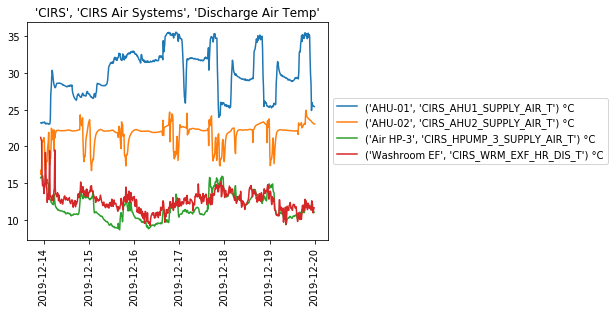

In [9]:
#After filtering out ['siteRef','groupRef','navName'] = ['CIRS','CIRS Air Systems','Discharge Air Temp'] 
#Visualize the values in each ['equipRef','typeRef'] group
#Note that df['value'] is string data
fig = plt.figure()
ax = fig.add_subplot(111)
#Iterate through the index of CIRS_Air_DAT (groups)
for gname,dfm in df.reset_index('time').groupby(level=['equipRef','typeRef']):
    #gname is a touple and dfm is a dataframe
    if len(dfm['unit'].unique()) != 1:        
        raise Exception("The data stream "+ str(gname) +" has not one singe unit "+ str(dfm['unit'].unique()))
    ax.plot(dfm['time'].values,  #index 'time' has been reset to a column
            dfm['value'].astype(float), #might need to use .fillna()
            label=str(gname)+" "+dfm['unit'].unique()[0])
# Shrink current axis by 10%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.9, box.height])
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation='vertical')
plt.title(str(fltr)[1:-1])
plt.show()